# Adding noise into a RT
I've been thinking how some frequency noise can be added on RT following the vinyet method, but with multifrequency. This could be done following some steps explained on the next parts.

### Previous consideration
Initially the simulations will be done with some conditions that will simplify the system. Those considerations are:
- Single frequency
- only one object will vibrate
- Ray direction is normal to the surface


### About the element
On the material, some new properties should be added, the primary new properties should be:
- Sequence of Amplitude vectors (instead of Normal + Amplitude module which requires more memory)
- frequency of each amplitude vibration  

<img src="img/mirror_modulation10.svg" width=200 height=200/>

Which would result in a structure that should look like:  

    Seq{f_1; f_2; ... ; f_n}    
    Seq{n_1; n_2; ...; n_n}

In [1]:
sampling
ray
array howto

input.fsx(1,1): error FS0039: The value or constructor 'sampling' is not defined

### About the sampling
In order to sample the movement I just should take into account the frequencies that I am addding into the mechanical element and the amplitude to avoid aliasing. This is done due to two effects, the first is the simple Nyquist theorem:
$$\Delta t_{sampling} < T/2 $$

And the second one comes from the upconversion phenomena which tell us that
$$ f_{max} = n \cdot f_{obj} $$
where $n$ refers to the nonlinear phenomena of upconversion produced because the mechanical object is moving with an amplitude bigger than the wavelength of light, i.e. $ A_{obj} >> \lambda $. Thus we obtain that
$$n = 2 A_{obj} / \lambda $$


$$f_{max} = \dfrac{2 A_{obj}}{ \lambda } 2\pi f_{obj}$$
Why there's the $2\pi$?!?!?  -> stupid you forgot it!
This means for a frequency of 1Hz at least I should sample at more than 2Hz, but more should be done

In any case, in order to do the sampling, first I should add into the object the vibration in the next way:
$$([|\,(\vec{A}_1 , f_1 );...;(\vec{A}_i , f_i );...; (\vec{A}_n , f_n )\, |],  [|\, t_1 ; ... ; t_n \,|]) $$
And the time sampling must be computed after the object is read. I mean it's done with the noise **(create a noise type)** and the input on the material is only the array of frequencies and amplitudes

## How to modify the ray
Once the ray hits the object which is vibrating, the ray must store the noise 

Since one of the members of the ray already is the noise, this means that the modifications must be applied on the noise type. Thus the noise will result as: $((\vec{A}, f ), [|..t..|]) $ And results something like:
$$ray = \{ray \;with\; PhaseModulation =  [|\phi (t_0 )..\phi (t_i )..|]) \} $$

## How to modify the objects
When the objects are modified, they also have to include the times at which the displacement of the vibrating objects is going to me computed. How?..

## Shading
The shading is the last and probably one of the most important parts of the code since expresses the interaction between the material and the light.
In my case I need:

    let PhaseModulation = t |> Array.map(fun x -> (2*PI/wavelengt)*A*sin(2*PI*f) )

And this is inside a funciton called **PhaseModulation**

In [2]:
// test on forward ray tacing
#r @"..\Types\bin\Debug\Types.dll"
#r @"..\RayTracing\bin\Debug\RayTracing.dll"
#r @"..\PostProcess\bin\Debug\PostProcess.dll"
//Math.Net
#r @"..\packages\MathNet.Numerics.3.11.1\lib\net40\MathNet.Numerics.dll"
#r @"..\packages\MathNet.Numerics.FSharp.3.11.1\lib\net40\MathNet.Numerics.FSharp.dll"

// libraries referenced


open Types.Algebra
open Types.ObjectTypes
open Types.types
open RayTracing.intersections
open Microsoft.FSharp.Data.UnitSystems.SI.UnitSymbols
open ForwardRayTracing
open SaveSensorInfo
open Random
open System.IO
open MathNet.Numerics.IntegralTransforms
open System.Numerics
open PostProcess.Noise

In [4]:
let r = {
         Wavelenght = WaveLength(5e-7<m>);
         from = Point(0.,00.00,0.5); uvec = UnitVector(0.,0.,-1.);
         MaxLength = infi;
         OpticalPathTravelled = 0.<m>;
         NumBounces = 0uy; bounces = [];
         MaxDispersions = 1uy;
         NumOfParticles = 1;
         IndexOfRefraction = 1.
        // NoiseAdd= [||]
         PhaseModulation = [||]
        }

let mout = [|{MatName= "Mirror"; R=1.; T=0.; n=(2.,WaveLength(5e-6 |> LanguagePrimitives.FloatWithMeasure<m>));LambPPM= 0.};
             {MatName= "Glass"; R=0.; T=1.; n=(1.3,WaveLength(5e-6 |> LanguagePrimitives.FloatWithMeasure<m>));LambPPM= 0.};
             {MatName= "air"; R=0.; T=1.; n=(1.,WaveLength(5e-6 |> LanguagePrimitives.FloatWithMeasure<m>));LambPPM= 0.}
             |]

let mat = dict (mout|> Array.map(fun x -> (x.MatName,x)))

In [5]:
//__SOURCE_DIRECTORY__
r

{Wavelenght = WaveLength 5e-07;
 from = Types.Algebra+Point;
 uvec = Types.Algebra+UnitVector;
 MaxLength = infinity;
 OpticalPathTravelled = 0.0;
 NumBounces = 0uy;
 MaxDispersions = 1uy;
 bounces = [];
 NumOfParticles = 1;
 IndexOfRefraction = 1.0;
 PhaseModulation = [||];}

## Simulate the reflection
The reflection is on a flat surface with the normal parallel to the ray direction as specified on the first image.
**More on the python doc **

Cases I want to show for the phase change:

- One with the simple case of the phase change going further than $\pi$
- One with the mod(phase) -  done on the original code
- One with some modifications on the simple output - modifications on python

In [57]:
//
//
// Next test the rays are reflected on a flat surface
//
//

let nNRM = UnitVector(0.,0.,1.)
let Pground = Point(0.,0.,0.)
let t = [|(0.)..(1./360.)..8.|]   // Temporal series for the phase scan
let freqs = [|(1uy, Vector(0.,0.,1.5e-6),PI/2.);(5uy, Vector(0.,0.,0.7e-6),PI)|]
let vibration = (freqs,t)
let ground = disc(Pground,100.,nNRM,"Mirror",Sensor(),vibration)  // Disc that represents the ground

// Source of Light
//  &
// sensor

let spoint = Point(0.,0.,3.)        // Sensor point centre
let lpoint = Point(0.,0.,3.)       // Light source centre
let snrm = UnitVector(0.0,0.,-1.)   // Sensor Direction
let lnrm = UnitVector(0.,0.,-1.)    // Light Direction
let sdisc = disc(spoint,3.5,snrm,true)      // Sensor
lnrm
let objs3 = [|Disc(ground);Disc(sdisc)|]


In [58]:
Array.length t//ground.

2881

In [59]:
[|r|] |> Array.iter(fun x -> ForwardRay(x,objs3,mat) )

<null>

In [56]:
sdisc.Sensor.SavedData.[0]

let ph = sdisc.Sensor.SavedData.[0].Noise |> Array.map(fun c -> string(c)) // :? Array
open System.IO
File.WriteAllLines(@"Vibration_2freq.txt", ph );

<null>

In [34]:
//ph |> Array.map(fun x ->  x
//ph.Length |> Display
//ph.[80..160] |> Display
//phar |> List.map (fun x -> snd x)

In [43]:
// Test to see which one is the fmax
let fmax A f lambda = 2.*2.*PI*(A/lambda)*f
let A0 = 0.45e-6
let A1 = 2e-6
let A2 = 0.7e-6
let fa = 5.
let lamb = 0.5e-6

let fm A = fmax A fa lamb
(fm(A0),fm(A1), fm(A2))

(56.54866776, 251.3274123, 87.9645943)

## **F# Fourier transform**

Here I'm going to do the fourier transform and test if I can do the things I did on the Python notebook
- FFT of the phase
- Plot the Amplitude Spectrum Density of the noise

To do that first I'll plot the phase (*ph*) and it's fourier transform

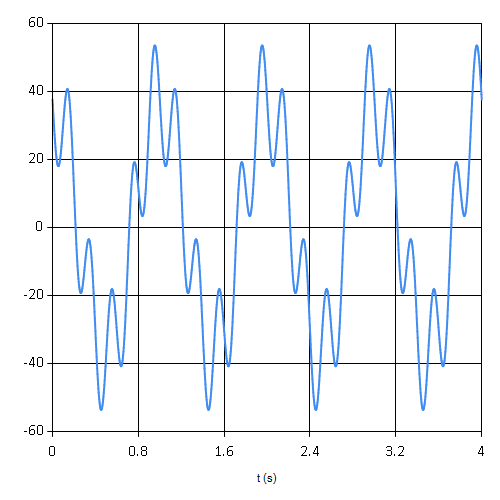

In [36]:
// Plot the phase
//let pltphase = (t,ph) ||> Array.map2(fun x y -> (x,y))
Chart.Line((t,ph) ||> Array.map2(fun x y -> (x,y)))
|> Chart.WithXAxis(Min= 0.,Max = 4., Title= "t (s)")
|> Chart.WithSize(500, 500)//|> Display

In [37]:
// transform the phase
let Fph = ph |> Array.map(fun x -> Complex(float x,0.))
Fourier.Forward(Fph) 

<null>

Things:
- Fisrt I plot the direct module of the Fourier transform of the phase and I find the frequency of the signal.
- Then I perform the same operation, but withouth the aproximation on the $sin(\Delta\phi) \sim  \Delta\phi$. This produces the upconverted frequencies


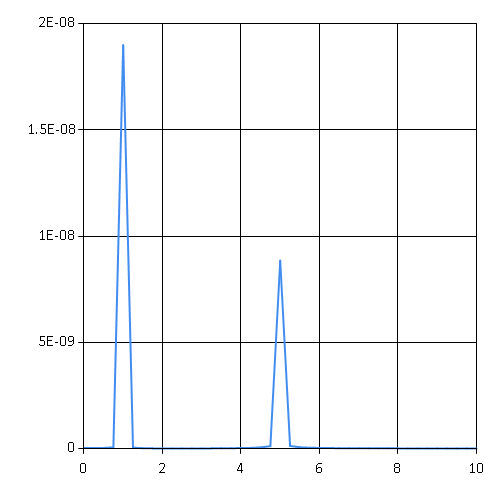

In [38]:
let fmin, fmax = 1./abs(t.[t.Length-1]-t.[0]), 0.5/abs(t.[1]-t.[0]) 
let freq = [|-fmax..fmin..fmax|]
let mult = 1e-6/3e3/4./PI  // things that multiply (phi)
// [360..(freq.Length-1)] .[0..360]
//(freq.Length)/2 |> Display
Chart.Line((freq.[(freq.Length)/2 ..(freq.Length-1)],Fph.[0..(freq.Length)/2])||> Array.map2(fun x y -> (x, mult*Complex.Abs(y))) )
|> Chart.WithXAxis(Min = 0., Max = 10.)
|> Chart.WithSize(500, 500)
//(freq.[360..(freq.Length-1)].Length,Fph.[0..360].Length)

In [20]:
// First the Sin of the phase:
let Sph = ph |> Array.map(fun x -> Complex(sin(float x),0.))
let FSph = Sph // Fourier
Fourier.Forward(FSph,FourierOptions.Default) 


<null>

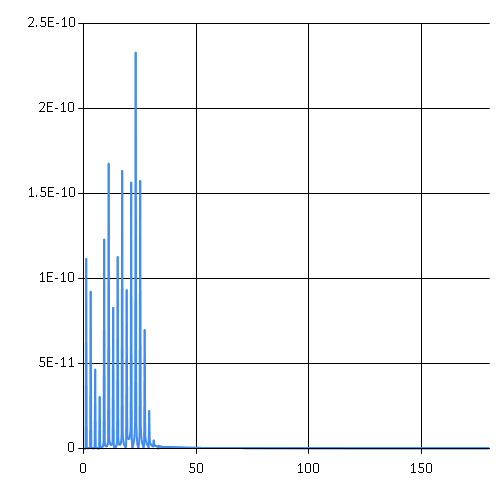

In [32]:
Chart.Line((freq.[(freq.Length)/2+1 ..(freq.Length-1)],FSph.[1..(freq.Length)/2])||> Array.map2(fun x y -> (x, (mult*Complex.Abs(y)))) )
//|> Chart.WithYAxis(Max=(-20.0),Min=(-32.0))
//|> Chart.WithXAxis(Min = 0.,Max =50.,  Title="log(f)")
|> Chart.WithSize(500, 500) 


In [35]:
let tph = FSph.[1..(freq.Length)/2] |> Array.map(fun c -> string(mult*Complex.Abs(c))) // :? Array
//open System.IO
File.WriteAllLines(@"fourier1mu.txt", tph );

<null>

Small test to see if $n(f) = \Delta \phi (f)$ checking if $\Delta \phi (f)$ is normalized:

In [145]:
let acum = FSph |> Array.map(fun x -> Complex.Abs(x)) |> Array.sum 
acum
//let sumArray array = Array.fold (fun acc elem -> acc + Complex.Abs(elem)) 0 array

162.6468446